<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.4.0
GPU detected: []


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [2]:
data = pd.read_csv('ner_dataset.csv', encoding='latin1')
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
print("Unique words in corpus: ", data['Word'].nunique())
print("Unique tags in corpus: ", data['Tag'].nunique())

Unique words in corpus:  35178
Unique tags in corpus:  17


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [5]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [6]:
num_words, num_tags

(35179, 17)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [7]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                          s["POS"].values.tolist(),
                                                          s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [8]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [9]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [10]:
# enumerate() -> add a counter to an iterable and returns it
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [11]:
word2idx

{'analysts': 1,
 'idled': 2,
 'stone-throwing': 3,
 'unfolding': 4,
 'sarcophagus': 5,
 '32': 6,
 'medium': 7,
 'boring': 8,
 'dehydration': 9,
 'Reinhold': 10,
 'Tangshan': 11,
 'pro-reform': 12,
 'rape': 13,
 'Buffeted': 14,
 'al-Ghazal': 15,
 'Griffin': 16,
 'extending': 17,
 'Transatlantic': 18,
 'spectator': 19,
 'Elahi': 20,
 'exported': 21,
 'principally': 22,
 'parking': 23,
 '140-kilometers': 24,
 'Hammond': 25,
 'paving': 26,
 'pain': 27,
 'Sheremetyevo': 28,
 'forcefully': 29,
 'Petronas': 30,
 'Osnabrueck': 31,
 'evidence': 32,
 'VI': 33,
 'Kengtung': 34,
 '--': 35,
 'unacceptable': 36,
 'buster': 37,
 'Australian-led': 38,
 'Barot': 39,
 'Moussaieff': 40,
 'apparent': 41,
 'Kanyarukiga': 42,
 'seabirds': 43,
 'basket': 44,
 'Chenembiri': 45,
 'Wanted': 46,
 'lightening': 47,
 'athlete': 48,
 '93': 49,
 'Tzotzil': 50,
 'second-place': 51,
 'Network': 52,
 'fifteen': 53,
 'artificial': 54,
 '112': 55,
 'Ilyushin': 56,
 'round-trip': 57,
 '297-for': 58,
 'stand': 59,
 'Cubape

In [12]:
tag2idx

{'B-org': 0,
 'I-gpe': 1,
 'I-per': 2,
 'B-eve': 3,
 'I-geo': 4,
 'B-gpe': 5,
 'I-nat': 6,
 'B-geo': 7,
 'I-eve': 8,
 'B-art': 9,
 'I-tim': 10,
 'I-org': 11,
 'O': 12,
 'B-nat': 13,
 'B-tim': 14,
 'I-art': 15,
 'B-per': 16}

### Task 5: Padding Input Sentences and Creating Train/Test Splits

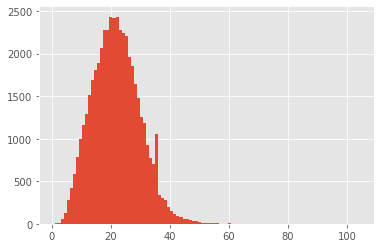

In [13]:
plt.hist([len(s) for s in sentences], bins=100)
plt.show()

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [16]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [17]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
# SpatialDropout1D -> rather than dropping dropping individual nodes, it drops the entire 1D feature map
model = SpatialDropout1D(0.1)(model)
# Rather than RNN, we are using LSTM to avoid Vanishing Gradient Problem
# using Bi-directional LSTM because, our model can learn from the entire input, rather than just the previous timestamps
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

### Task 7: Train the Model

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot import PlotLossesKeras
import keras

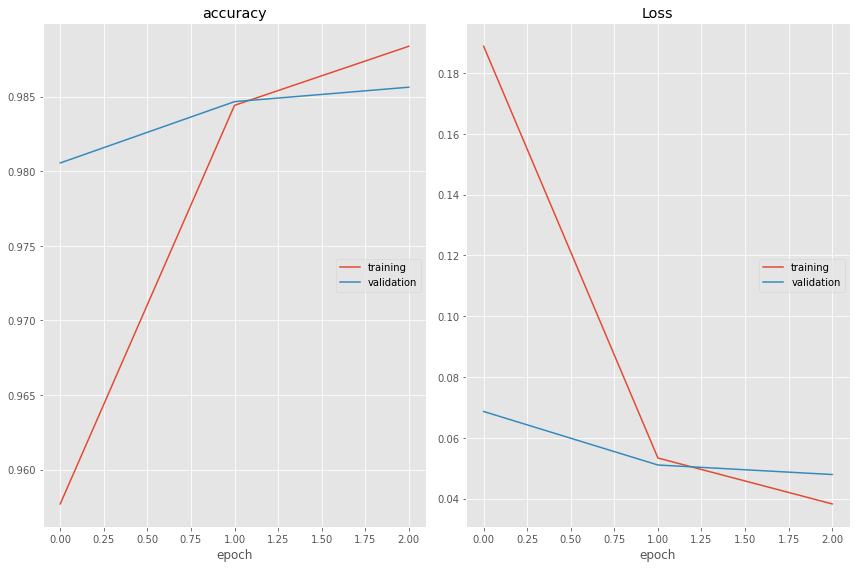

accuracy
	training         	 (min:    0.958, max:    0.988, cur:    0.988)
	validation       	 (min:    0.981, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.038, max:    0.189, cur:    0.038)
	validation       	 (min:    0.048, max:    0.069, cur:    0.048)


In [20]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesKeras(), early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=3,
    verbose=1,
    callbacks=callbacks
)

### Task 8: Evaluate Named Entity Recognition Model

In [21]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 3s 22ms/step - loss: 0.0496 - accuracy: 0.9850


[0.0496179535984993, 0.9849916696548462]

In [22]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t {}\n".format("word", "True", "Pred"))
print("-"*30)

for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

word           True 	 Pred

------------------------------
The            O	O
United         B-org	B-org
Nations        I-org	I-org
has            O	O
been           O	O
under          O	O
fire           O	O
for            O	O
failing        O	O
to             O	O
stop           O	O
ongoing        O	O
ethnic         O	O
violence       O	O
in             O	O
Ituri          B-geo	B-geo
.              O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journey        O	O
journ